# Mathematical Analysis of: Modeling shows that the NS5A inhibitor daclatasvir has two modes of action and yields a shorter estimate of the hepatitis C virus half-life

### Replication of Model Attempt 

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.integrate import odeint
import pandas as pd
from scipy.optimize import minimize
from scipy.optimize import curve_fit
from scipy.optimize import Bounds

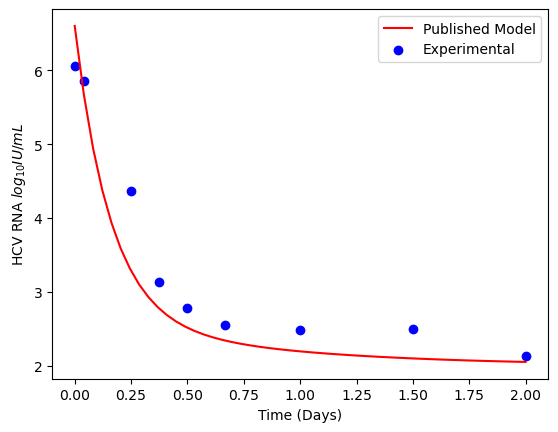

In [2]:
def Model(x, t):
    T = x[0]
    I = x[1]
    V = x[2]
    
    
    B =  3e-07
    delta =  1.06
    p = 8.3
    c = 6.2
    epsilon = 0.98
    Cp = c*(1-epsilon)
    d = np.log(2)/Cp
    T0 = c*delta/(p*B)
    s = T0*np.exp(t)
    
    dTdt = s - d*T - B*V*T
    dIdt = B*V*T - delta*I
    dVdt = (1-epsilon)*p*I - c*V + 2*6.06 
        
    return ([dTdt, dIdt, dVdt])
    
beta =  3e-07
rho = 8.3
c = 22.37
delta =  1.06

V0 = 6.6
I0 = c*V0/rho
T0 = c*delta/(rho*beta)
R0 = 15

# Initial conditions
x0 = [T0, I0, V0]  # Define initial values for T, I, V
t = np.linspace(0, 2, 50)  # Time array

# Solve the ODE system
sol1 = odeint(Model, x0, t)

# Retrieve results
T_result1 = sol1[:, 0]
I_result1 = sol1[:, 1]
V_result1 = sol1[:, 2]
plt.plot (t, V_result1, color = 'red', label = 'Published Model')


V_data1 = np.array([6.06,5.85,4.37,3.14,2.79,2.56,2.48,2.50,2.13])
Time_data1 = np.array([0,1,6,9,12,16,24,36,48])/24


plt.scatter(Time_data1, V_data1, color = 'blue', label = 'Experimental')
plt.xlabel('Time (Days)')
plt.ylabel('HCV RNA $log_{10} IU/mL$')
plt.legend()
plt.show()

#### Unsuccessful in accurately replicating the model shown in the publication. The model, however, is of decent quality and fits the experimental data fairly well. 

### Construction of my own model and optimized parameters

In [3]:
def My_Model(x, t, params):
    T = x[0]
    I = x[1]
    V = x[2]
    
    epsilon, c, delta = params
    
    
    B =  3e-07
    p = 8.3
    Cp = c*(1-epsilon)
    d = np.log(2)/Cp
    T0 = c*delta/(p*B)
    s = T0*np.exp(t)
    
    dTdt = s - d*T - B*V*T
    dIdt = B*V*T - delta*I
    dVdt = (1-epsilon)*p*I - c*V 
        
    return ([dTdt, dIdt, dVdt])

Int_vals = np.array([0.5, 20, 1])

def Cost_Func(params, *args):
    Opt_params = params
    V_data, Time_data, Int_vals = args 
    
    model_result = odeint(My_Model, Int_vals, Time_data, args=(Opt_params,))
    
    error_func = np.sum((model_result[:, 2] - V_data) ** 2)
    return error_func

Params_guess = np.array([0.999, 22.4, 1.06])

Bounds = ((0,0.99), (1,100), (1.0897,10))
# Using a different optimization method that supports bounds
sol = minimize(Cost_Func, Params_guess, args=(V_data1, Time_data1, Int_vals), method='L-BFGS-B', bounds=Bounds)

Sol_params = sol.x 

print(Sol_params)

[ 0.48803394 22.31712383  1.16517257]


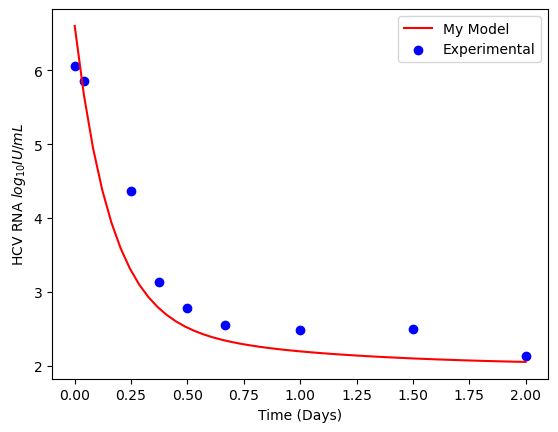

In [4]:
#My Opt parameters
epsilon = Sol_params[0]
c = Sol_params[1]
delta = Sol_params[2]

def Revised_Model(x, t, params):
        T = x[0]
        I = x[1]
        V = x[2]
    
        epsilon, delta, c = params
    
        
        B =  3e-07
        p = 8.3
        Cp = c*(1-epsilon)
        d = np.log(2)/Cp
        T0 = c*delta/(p*B)
        s = T0*np.exp(t)
    
        dTdt = s - d*T - B*V*T
        dIdt = B*V*T - delta*I
        dVdt = (1-epsilon)*p*I - c*V 
        
        return ([dTdt, dIdt, dVdt])
    
    
    


# Initial conditions
x0 = [T0, I0, V0]  # Define initial values for T, I, V
t = np.linspace(0, 2, 50)  # Time array

# Solve the ODE system
sol = odeint(Model, x0, t)

# Retrieve results
T_result = sol[:, 0]
I_result = sol[:, 1]
V_result = sol[:, 2]
plt.plot (t, V_result, color = 'red', label = 'My Model')

plt.scatter(Time_data1, V_data1, color = 'blue', label = 'Experimental')
plt.xlabel('Time (Days)')
plt.ylabel('HCV RNA $log_{10} IU/mL$')
plt.legend()
plt.show()

#### Conclusion: Model still falls short in comparison to the model in the paper. I obtained new model parameters within the appropiate bounds of the system but the model still demonstrates the same approximate error. 

### Bifurcation Analysis

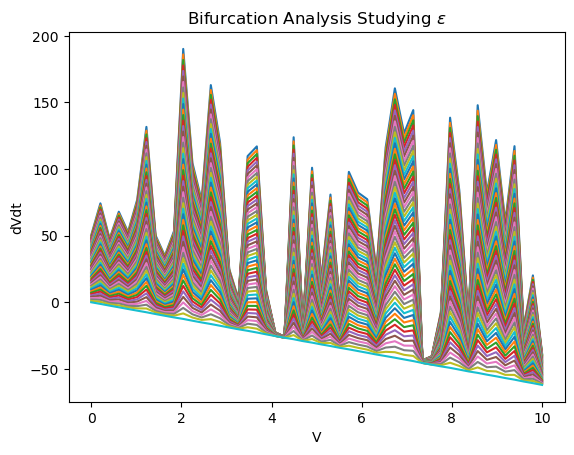

In [29]:
I = np.random.uniform(0, 25, 50)
epsilon_range = np.linspace(1e-04, 0.999, 50)
V_range = np.linspace(0, 10, 50)

dVdt_new = np.zeros((len(epsilon_range), len(V_range)))

# Perform bifurcation analysis
for i in range(len(epsilon_range)):
    for j in range(len(V_range)):
        dVdt_new[i][j] = (1 - epsilon_range[i]) * p * I[j] - c * V_range[j]

# Filter values within the desired range and store indices
threshold_indices = np.where(np.logical_and(dVdt_new > -0.01, dVdt_new < 0.01))

# Get unique 'i' indices from threshold_indices
unique_i_indices = np.unique(threshold_indices[0])

# Create a storage array to hold the relevant values
storage = np.zeros(len(epsilon_range))

# Extract 'dVdt' values within the desired range
for idx in unique_i_indices:
    storage[idx] = dVdt_new[idx][threshold_indices[1][threshold_indices[0] == idx][0]]

# Plot the bifurcation diagram
for i in range(len(epsilon_range)):
    plt.plot(V_range, dVdt_new[i], label=f'$\epsilon$: {epsilon_range[i]}')

plt.scatter(V_range[threshold_indices[1]], dVdt_new[threshold_indices], color='red', s=5, label='Within Range')
plt.title('Bifurcation Analysis Studying $\epsilon$')
plt.ylabel('dVdt')
plt.xlabel('V')
plt.show()

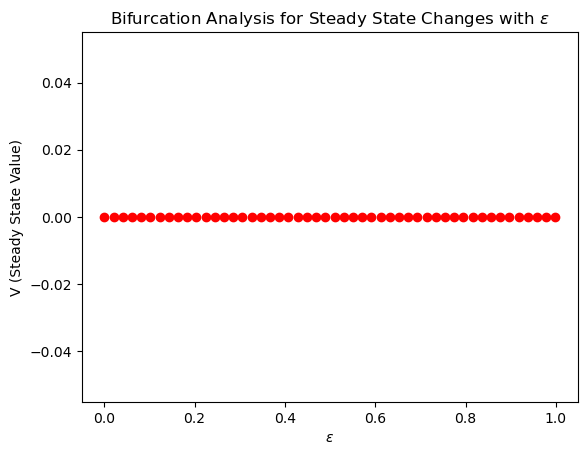

In [30]:
plt.plot(epsilon_range,storage,'ro');
plt.title('Bifurcation Analysis for Steady State Changes with $\epsilon$');
plt.ylabel('V (Steady State Value)');
plt.xlabel('$\epsilon$');


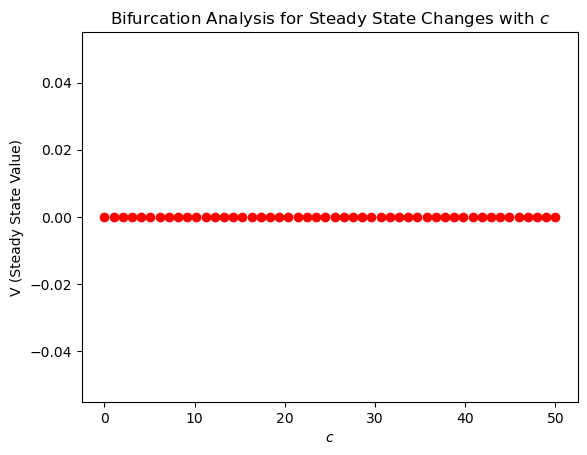

In [22]:
I = np.random.uniform(0, 25, 50)
c_range = np.linspace(0, 50, 50)
V_range = np.linspace(0, 10, 50)

dVdt_new = np.zeros((len(c_range), len(V_range)))

# Perform bifurcation analysis
for i in range(len(c_range)):
    for j in range(len(V_range)):
        dVdt_new[i][j] = (1 - epsilon) * p * I[j] - c_range[i] * V_range[j]

# Filter values within the desired range and store indices
threshold_indices = np.where(np.logical_and(dVdt_new > -0.01, dVdt_new < 0.01))

unique_i_indices = np.unique(threshold_indices[0])

storage = np.zeros(len(c_range))

# Extract 'dVdt' values within the desired range
for idx in unique_i_indices:
    storage[idx] = V_range[threshold_indices[1][threshold_indices[0] == idx][0]]

# Plotting
plt.plot(c_range, storage, 'ro')
plt.title('Bifurcation Analysis for Steady State Changes with $c$')
plt.ylabel('V (Steady State Value)')
plt.xlabel('$c$')
plt.show()

#### Conclusion: The bifurcation analysis results suggest that the Steady State value of 0 for the viral volume is stable through parametric sweeps of $\epsilon$ and $c$.

### Sensitivity Analysis

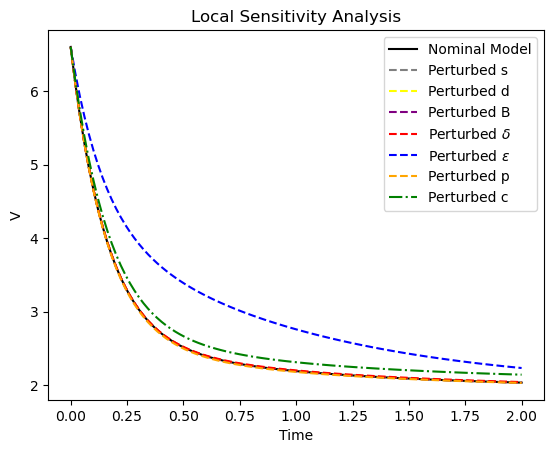

In [5]:
def sens(x, t, s, d, B, delta, epsilon, p, c):
    T = x[0]
    I = x[1]
    V = x[2]
    
    dTdt = s - d * T - B * V * T
    dIdt = B * V * T - delta * I
    dVdt = (1 - epsilon) * p * I - c * V + 2*6.06   
        
    return [dTdt, dIdt, dVdt]

# Initial values for T, I, and V

IV = np.array([T0, I0, V0])

# Time steps
timesteps = np.linspace(0, 2, 100)

# Parameters
s = 100
B = 3e-07
delta = 1.06
p = 8.3
c = 6.2
epsilon = 0.98
Cp = c * (1 - epsilon)
d = np.log(2) / Cp

nomial_model = odeint(sens, IV, timesteps, args=(s, d, B, delta, epsilon, p, c))
x1 = odeint(sens, IV, timesteps, args=(s*0.95, d, B, delta, epsilon, p, c))
x2 = odeint(sens, IV, timesteps, args=(s, d*0.95, B, delta, epsilon, p, c))
x3 = odeint(sens, IV, timesteps, args=(s, d, B*0.95, delta, epsilon, p, c))
x4 = odeint(sens, IV, timesteps, args=(s, d, B, delta*0.95, epsilon, p, c))
x5 = odeint(sens, IV, timesteps, args=(s, d, B, delta, epsilon * 0.95, p, c))
x6 = odeint(sens, IV, timesteps, args=(s, d, B, delta, epsilon , p*0.95, c))
x7 = odeint(sens, IV, timesteps, args=(s, d, B, delta, epsilon , p, c*0.95))

plt.plot(timesteps, nomial_model[:, 2], color='black', label='Nominal Model')
plt.plot(timesteps, x1[:, 2], '--', color='gray', label='Perturbed s')
plt.plot(timesteps, x2[:, 2], '--', color='yellow', label='Perturbed d')
plt.plot(timesteps, x3[:, 2], '--', color='purple', label='Perturbed B')
plt.plot(timesteps, x4[:, 2], '--', color='red', label='Perturbed $\delta$')
plt.plot(timesteps, x5[:, 2], '--', color='blue', label='Perturbed $\epsilon$')
plt.plot(timesteps, x6[:, 2], '--', color='orange', label='Perturbed p')
plt.plot(timesteps, x7[:, 2], '-.', color='green', label='Perturbed c')
plt.xlabel('Time')
plt.ylabel('V')
plt.legend()
plt.title('Local Sensitivity Analysis')
plt.show()

#print(nomial_model[-1,2])
norm_V = nomial_model[-1,2]

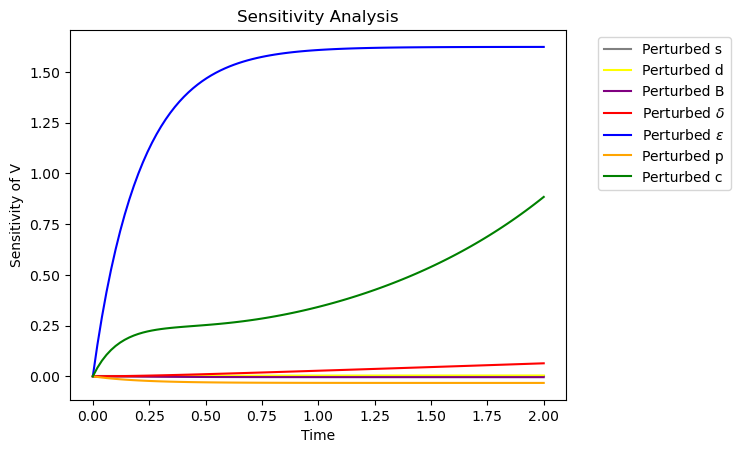

In [6]:
plt.plot(timesteps, ((x1[:,2] - nomial_model[:,2])/nomial_model[:,1])/0.05,color='gray', label='Perturbed s')
plt.plot(timesteps, ((x2[:,2] - nomial_model[:,2])/nomial_model[:,1])/0.05,color='yellow', label='Perturbed d')
plt.plot(timesteps, ((x3[:,2] - nomial_model[:,2])/nomial_model[:,1])/0.05,color='purple', label='Perturbed B')
plt.plot(timesteps, ((x4[:,2] - nomial_model[:,2])/nomial_model[:,1])/0.05,color='red', label='Perturbed $\delta$')
plt.plot(timesteps, ((x5[:,2] - nomial_model[:,2])/nomial_model[:,1])/0.05,color='blue', label='Perturbed $\epsilon$')
plt.plot(timesteps, ((x6[:,2] - nomial_model[:,2])/nomial_model[:,1])/0.05,color='orange', label='Perturbed p')
plt.plot(timesteps, ((x7[:,2] - nomial_model[:,2])/nomial_model[:,1])/0.05,color='green', label='Perturbed c')
plt.xlabel('Time')
plt.ylabel('Sensitivity of V')
plt.title('Sensitivity Analysis')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

#### Conclusion: The local sensitivity analysis suggests that $\epsilon$ is most sensitive to small perturbations followed by $c$ then $\delta$.

#### Global Sensitivity Analysis Varying All Parameters

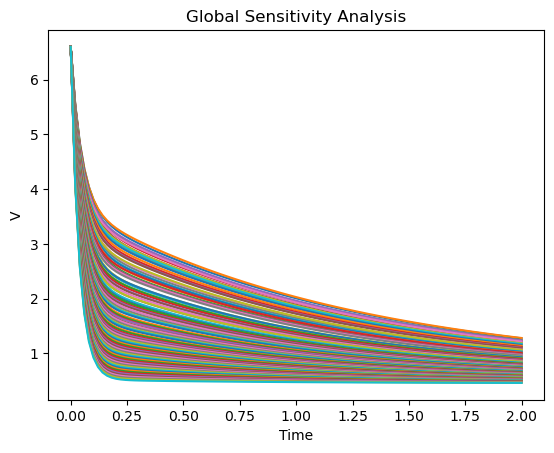

In [7]:
N = 100
timsteps = np.linspace(0,2,N)
V = np.zeros(N)
# New Global Parameter Space
s_new = np.random.uniform(80,120,N)
B_new = np.linspace(1.5e-06,1.5e-08,N)
delta_new = np.linspace(0.8,1.2,N)
p_new = np.linspace(6,10,N)
c_new = np.linspace(17.9,26.8,N)
epsilon_new = np.linspace(0.6,0.99, N)
Cp_new = c * (1 - epsilon)
d_new = np.random.uniform(15,25,N)


for m in np.arange(0,N,1):
    output = odeint(sens, IV, timesteps, args=(s_new[m], d_new[m], B_new[m], delta_new[m], epsilon_new[m], p_new[m], c_new[m]));
    plt.plot(timesteps,output[:,2]);
    plt.xlabel("Time");
    plt.ylabel("V");
    plt.title('Global Sensitivity Analysis')
    V[m]=output[-1,1];

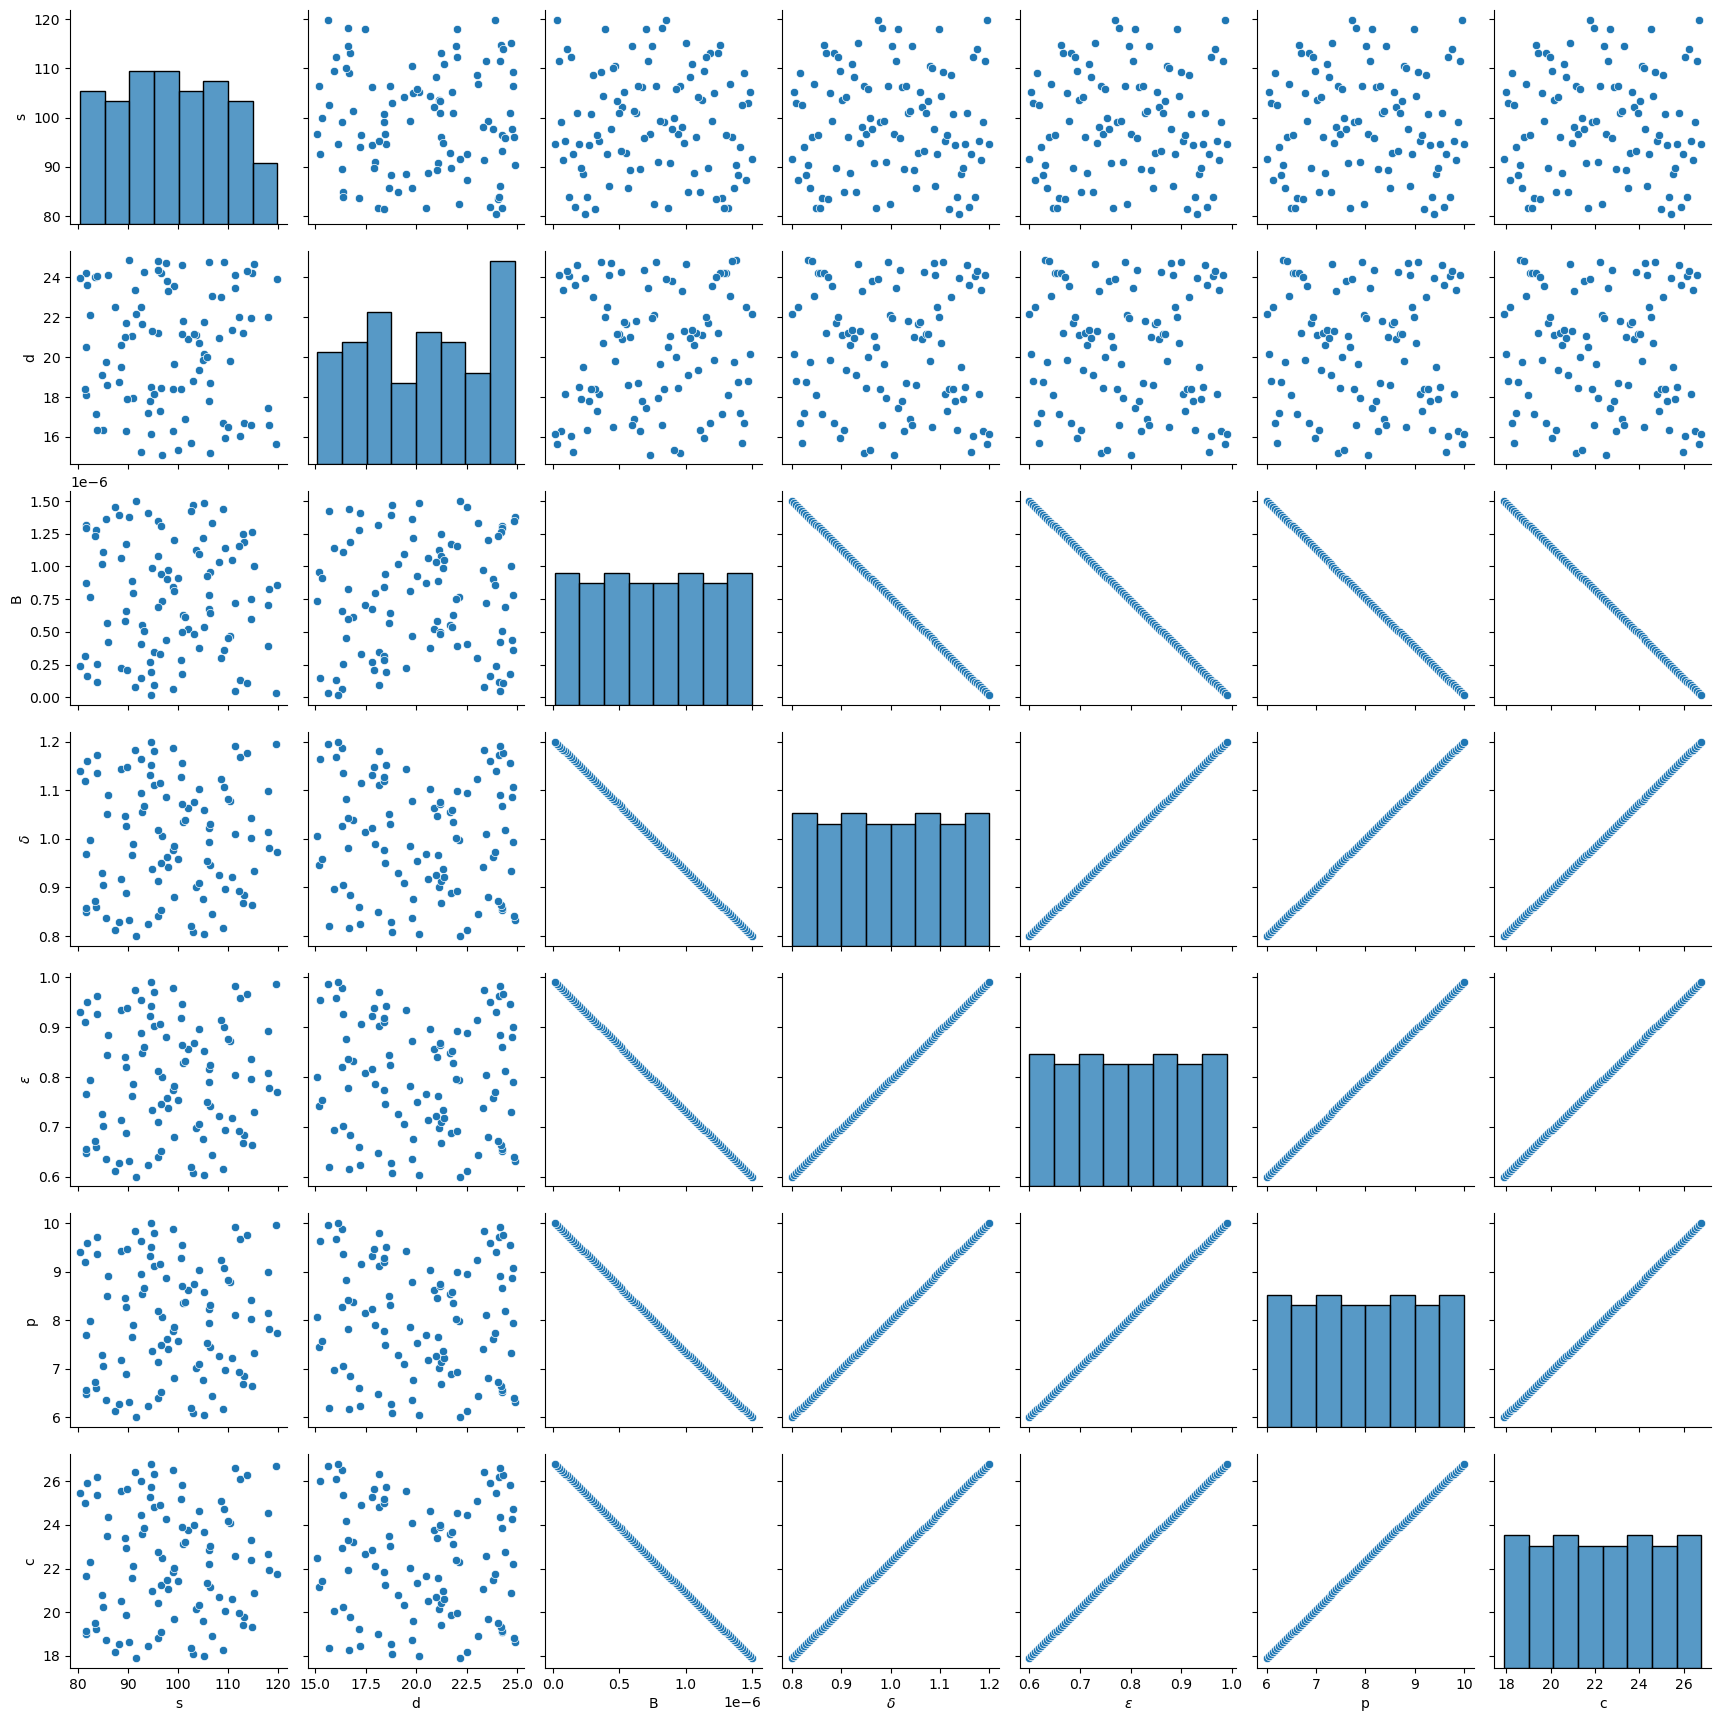

In [8]:
import pandas as pd
import seaborn as sns

d_new = np.random.uniform(15,25,N)

tmp = {'s':s_new, 'd':d_new, 'B':B_new, '$\delta$':delta_new, '$\epsilon$':epsilon_new, 'p':p_new, 'c':c_new};
df = pd.DataFrame(tmp);
del(tmp)

sns.pairplot(df)
20
plt.show()

#### Global Sensitivity Analysis Varying the Main Parameters ($c, \epsilon, \delta$)

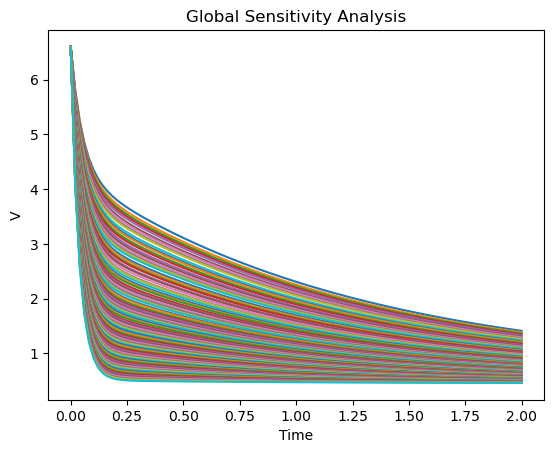

In [9]:
_new = np.random.uniform(100,10,N)
B_new = np.linspace(3e-07,3e-07,N)
delta_new = np.linspace(0.8,1.2,N)
p_new = np.linspace(8.3,8.3,N)
c_new = np.linspace(17.9,26.8,N)
epsilon_new = np.linspace(0.6,0.99, N)
Cp_new = c * (1 - epsilon)
d_new = np.random.uniform(15,25,N)


for m in np.arange(0,N,1):
    output = odeint(sens, IV, timesteps, args=(s_new[m], d_new[m], B_new[m], delta_new[m], epsilon_new[m], p_new[m], c_new[m]));
    plt.plot(timesteps,output[:,2]);
    plt.xlabel("Time");
    plt.ylabel("V");
    plt.title('Global Sensitivity Analysis')
    V[m]=output[-1,1];

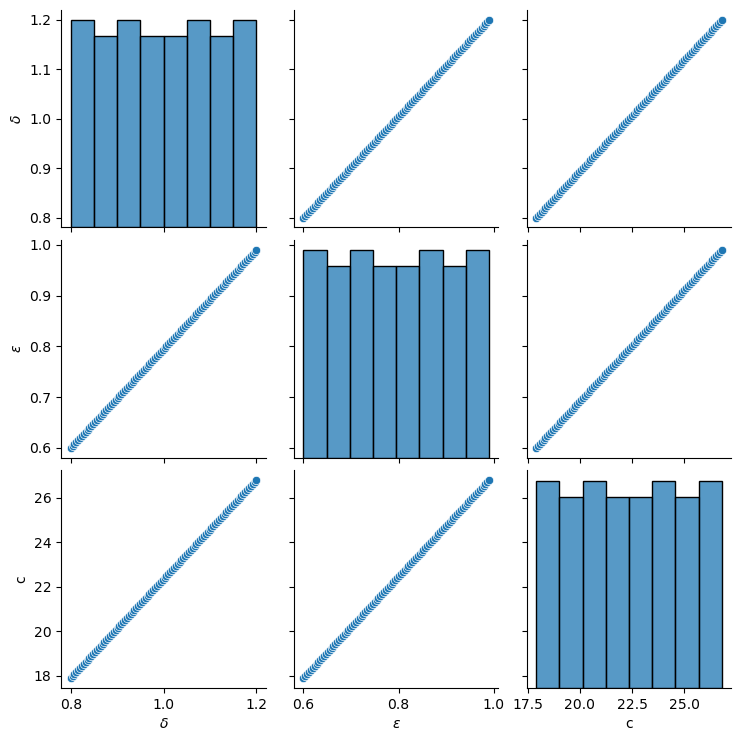

In [10]:
tmp = {'$\delta$':delta_new, '$\epsilon$':epsilon_new, 'c':c_new};
df = pd.DataFrame(tmp);
del(tmp)

sns.pairplot(df)
20
plt.show()

Our fitted equn is y =  1.1989035946901303 epsilon +  -1.0620249797851782 c + -3.9184419100537644 delta


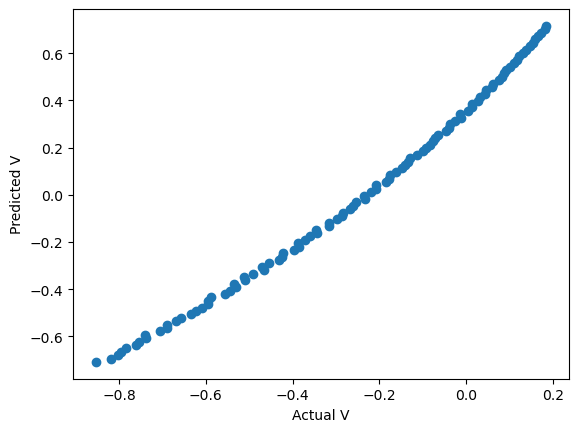

In [11]:
# Normalize x
x = (norm_V - V)/norm_V; 


# Build our X. Normalize values
X = np.c_[(0.98-epsilon_new)/0.98,(22.37-c_new)/22.37,(1.06-delta_new)/1.06]

# Now can just do the linear least squares estimate
#===================================================

from numpy.linalg import inv
tmp = inv(np.matmul(np.transpose(X),X));

params = tmp @ np.transpose(X) @ x;
print("Our fitted equn is y = ",params[0], "epsilon + ", params[1], "c +", params[2],"delta")

plt.plot(x,X @ params,"o");
plt.ylabel("Predicted V");
plt.xlabel("Actual V");

#### Conclusion: The local sensitivity analysis suggests that $\epsilon$ induced the greatest change of viral volume ($V$) upon small perturbations of the parameters. The global sensitivity analysis demonstrated that the rate of infected cell death ($\delta$) had the greatest influence upon large perturbatios.  